# Task 2 extra: Clustering

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances

## Loading the Customer Profile model

In [49]:
extra_customer_profile = pd.read_csv('../dataset/extra_customer_profile_model.csv', sep='\t', index_col=0)
extra_customer_profile

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6
CustomerID,,,,,,,,,
12347.0,2.777935,21.833078,0.000000,3.209929,1.320101,11.975399,12.485097,25.058849,24.117547
12348.0,2.417438,31.869869,0.000000,0.000000,23.461323,0.000000,2.600581,0.000000,42.068227
12349.0,3.163623,27.228568,0.000000,0.650407,8.006586,9.470001,19.373606,15.696889,19.573943
12350.0,2.468938,58.695652,0.000000,0.000000,11.820652,0.000000,0.000000,0.000000,29.483696
12352.0,2.324080,30.073257,0.000000,1.185387,4.020831,2.586513,19.503560,24.150275,18.480176
...,...,...,...,...,...,...,...,...,...
18280.0,2.256718,60.908084,0.000000,0.000000,0.000000,0.000000,0.000000,9.800664,29.291251
18281.0,1.907519,20.972532,0.000000,18.708241,0.000000,20.415739,0.000000,20.972532,18.930958
18282.0,1.945961,21.002265,0.000000,2.853907,0.000000,10.022650,7.061155,31.200453,27.859570


## Standardization \& Dimensionality Reduction

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

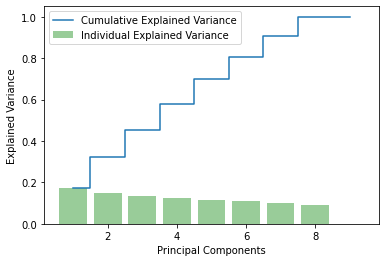

In [51]:
scaler = StandardScaler()
std_extra_customer_profile = scaler.fit_transform(extra_customer_profile)

pca = PCA()
pca.fit(std_extra_customer_profile)

plt.step(range(1, extra_customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, extra_customer_profile.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='upper left');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 7 components.

In [52]:
pca = PCA(n_components=6)
pca_extra_customer_profile = pca.fit_transform(std_extra_customer_profile)

## Data Visualization


t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

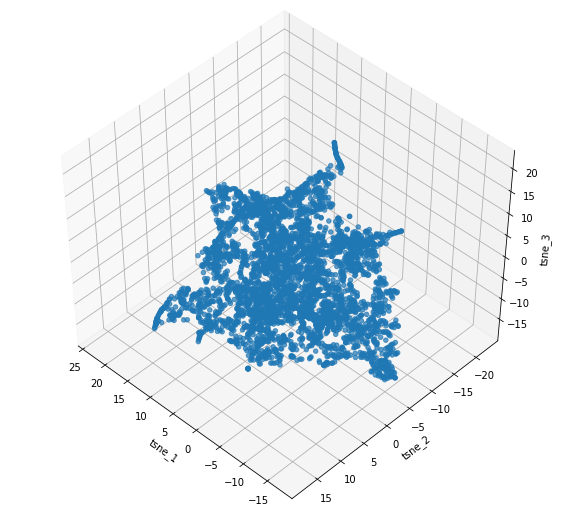

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_extra_customer_profile = tsne.fit_transform(pca_extra_customer_profile)
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*tsne_extra_customer_profile.T, s=20, alpha=0.7)
ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3');

## K-Means

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [55]:
def plot_silhouette_score(df, labels):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(df, labels)

    y_ax_lower, y_ax_upper = 0, 0
    y_tick = []

    for i, c in enumerate(cluster_labels):
    
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
    
        print('Cluster', c, 'avg silhouette:', np.mean(c_silhouette_vals))
    
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_tick.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    print('Total avg silhouette:', silhouette_avg)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.yticks=(y_tick, cluster_labels + 1)
    plt.ylabel('Points')
    plt.xlabel('Silhouette')
    plt.tight_layout()

In [56]:
silhouette = dict()
for k in range(2, 15):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_extra_customer_profile)
    silhouette[k] = silhouette_score(pca_extra_customer_profile, clusters)

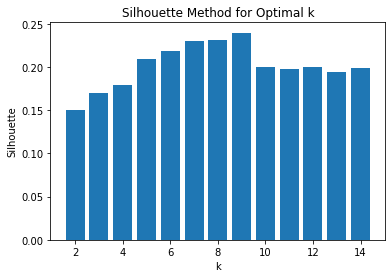

In [57]:
plt.bar(silhouette.keys(), silhouette.values())
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [58]:
print('The best silhouette score is:', max(silhouette.values()))

The best silhouette score is: 0.23980475837926568


In [59]:
kmeans = KMeans(init='k-means++', n_clusters=9)
clusters_customers = kmeans.fit_predict(pca_extra_customer_profile)

Cluster 0 avg silhouette: 0.1899053096850219
Cluster 1 avg silhouette: 0.2499895129989465
Cluster 2 avg silhouette: 0.21665897993586852
Cluster 3 avg silhouette: 0.269082587611787
Cluster 4 avg silhouette: 0.11053224057331403
Cluster 5 avg silhouette: 0.20309219089969807
Cluster 6 avg silhouette: 0.2535532507421543
Cluster 7 avg silhouette: 0.4055934791457478
Cluster 8 avg silhouette: 0.2441143508866796
Total avg silhouette: 0.23877365777680676


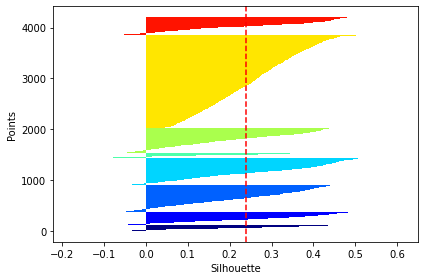

In [60]:
plot_silhouette_score(pca_extra_customer_profile, clusters_customers)

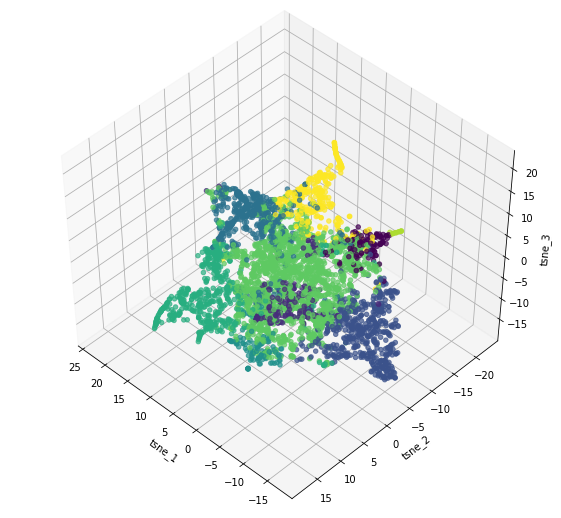

In [61]:
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*tsne_extra_customer_profile.T, c=clusters_customers, s=20, alpha=0.7)
ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3');

In [62]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8
CustomersNb,115,256,541,515,110,491,1818,12,348


In [63]:
extra_customer_profile_kmeans = extra_customer_profile.copy(deep=True)
extra_customer_profile_kmeans['cluster'] = clusters_customers
extra_customer_profile_kmeans

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,cluster
CustomerID,,,,,,,,,,
12347.0,2.777935,21.833078,0.000000,3.209929,1.320101,11.975399,12.485097,25.058849,24.117547,6
12348.0,2.417438,31.869869,0.000000,0.000000,23.461323,0.000000,2.600581,0.000000,42.068227,6
12349.0,3.163623,27.228568,0.000000,0.650407,8.006586,9.470001,19.373606,15.696889,19.573943,6
12350.0,2.468938,58.695652,0.000000,0.000000,11.820652,0.000000,0.000000,0.000000,29.483696,5
12352.0,2.324080,30.073257,0.000000,1.185387,4.020831,2.586513,19.503560,24.150275,18.480176,6
...,...,...,...,...,...,...,...,...,...,...
18280.0,2.256718,60.908084,0.000000,0.000000,0.000000,0.000000,0.000000,9.800664,29.291251,5
18281.0,1.907519,20.972532,0.000000,18.708241,0.000000,20.415739,0.000000,20.972532,18.930958,4
18282.0,1.945961,21.002265,0.000000,2.853907,0.000000,10.022650,7.061155,31.200453,27.859570,6


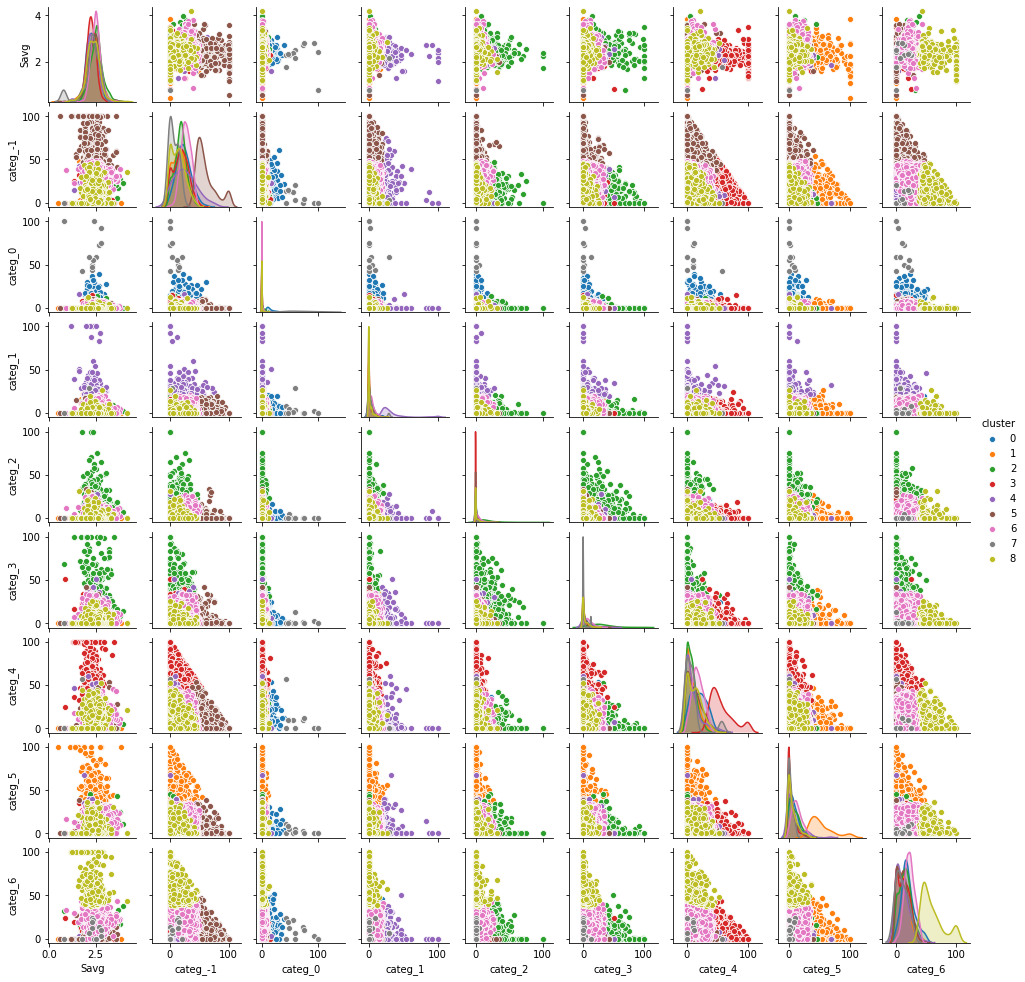

In [64]:
sns.pairplot(extra_customer_profile_kmeans, hue='cluster', diag_kind='kde', height=1.5);

In [65]:
extra_customer_profile_kmeans.to_csv('../dataset/extra_customer_profile_kmeans.csv', sep='\t')